# 1. Get everything ready

## 1.1. What is Google Colab?
Google Colab is a service from Google that allows us to develop and run programs on their powerful servers (GPUs and TPUs). This is easy because if we did this locally it would take much longer!
## 1.2. Make a copy of this file in your Google Drive.
Make your own copy of this file in your own Google Drive. Go to **File** and click **Save a copy in Drive**. Give the file a name of your choice. We do this because otherwise we would all be working in the same file - and that would lead to problems.

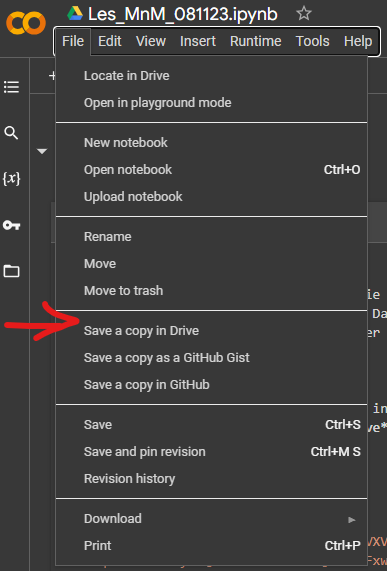

## 1.2. Connect to the Google Server
We connect this Notebook to Google's server (GPU or TPU). We do this by clicking on **Change Runtime Type** in the upper right corner. Then we choose TPU or GPU, which will depend on what is available at the time.
We click on **save**.

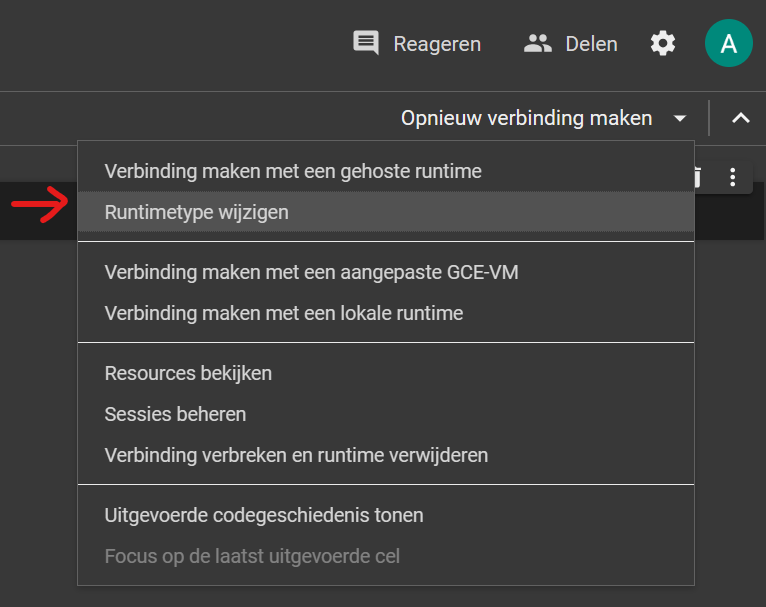

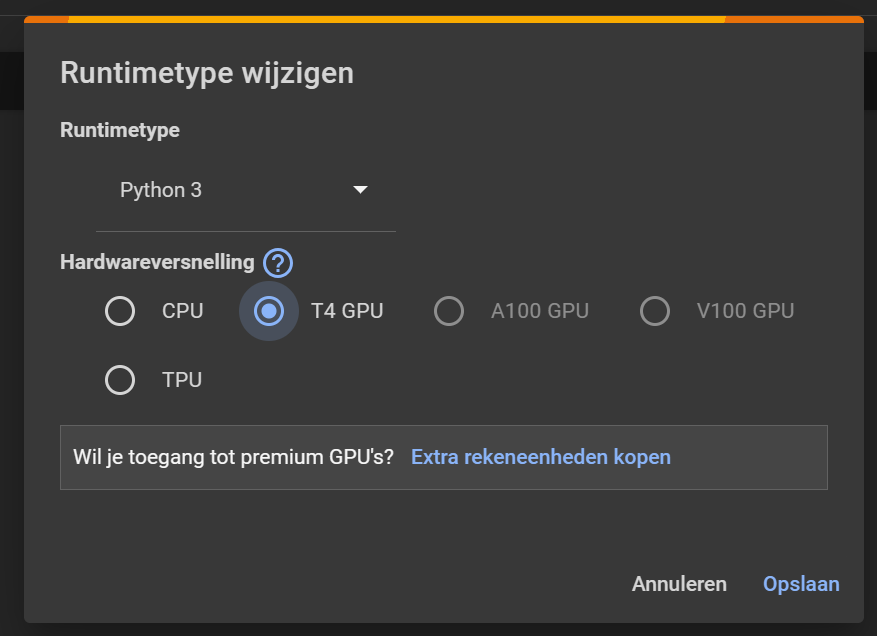


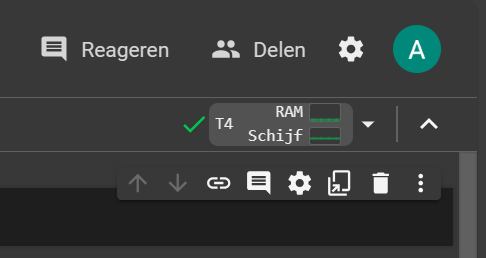

# 2. Load and install packages

In [ ]:
#%pip install spacy
%pip install dkpro-cassis

!python -m spacy download en_core_web_lg

In [ ]:
import glob
import pandas as pd

import spacy
from spacy import displacy
from cassis import *

# 3. Load travelogues

In this code snippet we collect the travelogues from a GitHub repository. You'll see a folder named **Workshop_Inception**, which contains four subfolders: **Dutch, English, French** and **German**. Each contain travelogues in these respective languages as text files.


We want to focus on the English texts for now!

In [ ]:
!git clone https://github.com/TessDejaeghere/annotation_workshop.git
!unzip /content/annotation_workshop/Workshop_Inception.zip

In [ ]:
folder_path = "/content/Workshop_Inception/English"

In [ ]:
txt_paths = glob.glob(folder_path + "/**/**/*.txt", recursive=True) #find all txt files paths in subfolders

In [ ]:
travelogues = {}

for path in txt_paths:
    path_elements = path.split("/")
    file_name = path_elements[-1].strip(".txt")

    text = open(path, "r")
    travelogue_content = text.read()

    language = path_elements[-3]

    travelogues[file_name] = travelogue_content

In [ ]:
travelogues_df = pd.DataFrame.from_dict(travelogues, orient='index', columns = ["Travelogues"])
travelogues_df.reset_index(inplace=True, names = ["ID"])

Let's have a look at the texts we have gathered!

In [ ]:
travelogues_df

# 4. Annotate an example text

The open-source tool we will use to bootstrap our texts is **spaCy**. SpaCy has models that recognize a lot of other entities in [different languages](https://spacy.io/usage/models/).
Among others, SpaCy recognizes the following entities in **English**:

Entity | Description
-------------|------------
PERSON:      |People, including fictional.
NORP:        |Nationalities or religious or political groups.
FAC:         |Buildings, airports, highways, bridges, etc.
ORG:         |Companies, agencies, institutions, etc.
GPE:         |Countries, cities, states.
LOC:         |Non-GPE locations, mountain ranges, bodies of water.
PRODUCT:     |Objects, vehicles, foods, etc. (not services.)
EVENT:       |Named hurricanes, battles, wars, sports events, etc.
WORK_OF_ART: |Titles of books, songs, etc.
LAW:         |Named documents made into laws.
LANGUAGE:    |Any named language.
DATE:        |Absolute or relative dates or periods.
TIME:        |Times smaller than a day.
PERCENT:     |Percentage, including ”%“.
MONEY:       |Monetary values, including unit.
QUANTITY:    |Measurements, as of weight or distance.
ORDINAL:     |“first”, “second”, etc.
CARDINAL:    |Numerals that do not fall under another type.


Let's see what spaCy can do for us!



In [ ]:
travelogue_ID, example_travelogue = next(iter(travelogues.items()))

In [ ]:
example_travelogue

'Author: Le Vaillant, François,\nTitle: Le Vaillant, François,\nLanguage: English\nHaving covered it with a few branches, and tied my handkerchief to the end of a pole, which I fixed in the ground, to frighten away ferocious animals, we set out in pursuit of the rest of the koedoes; because, the male being killed, I was certain that the females would not go far. We observed some traces of blood, which plainly showed that one of them had been wounded; and indeed, at the distance of four hundred paces, we found one just expiring. My Hottentot, whom I had reproached for shooting badly, was highly flattered by this event; but he had taken aim at the male, and it was by chance that he hit the female. Having skinned it, and taken out its bowels, we thought we might then both of us be able, as the distance was not very great, to convey it to the spot where we had left the male. Being considerably fatigued by this labor, and our appetite beginning to be whetted, we kindled a few sticks, and 

In [ ]:
# Process the document
nlp = spacy.load("en_core_web_lg")
doc = nlp(example_travelogue)

# Render the Named Entities recognized by spaCy in a nice visualisation
displacy.render(doc, style="ent", jupyter=True)

# 5. Bootstrapping with spaCy

To import the annotations in our annotation platform INCEPTION, we need to transform the automatic annotations by spaCy into a data format the platform will understand. In this case, we're transforming the output of spaCy to UIMA CAS XMI (XML 1.0.).

To do this, we have to load the typesystem file **typesystem_inception.xml** (the basic structure of the XML file) which will be used to structure our new annotations.



In [ ]:
with open("/content/Workshop_Inception/typesystem_inception.xml", "rb") as f:
  ts = load_typesystem(f)

In [ ]:
# Create the CAS
SENTENCE_TYPE = "de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence"
TOKEN_TYPE = "de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token"
NER_TYPE = "webanno.custom.NamedEntities" # This is the Internal Name in the layer settings of inception

First things first, we're not interested in all entity types!
We only want to add annotations for

Entity | Description
-------------|------------
PERSON:      |People, including fictional.
NORP:        |Nationalities or religious or political groups.
LOC:         |Buildings, airports, highways, bridges, etc.
ORG:         |Companies, agencies, institutions, etc.
GPE:         |Countries, cities, states.
FAUNA:         |Names of animals, including fictional. Both common names and scientific names.
FLORA:     |Names of plants, including fictional. Both common names and scientific names
WORK OF ART:     |Titles of books, songs, etc.


 **PERSON, ORG (organisation), LOC (location), WORK OF ART, and NORP (nationalities)**.

In [ ]:
entities = ["PERSON", "ORG", "LOC", "WORK_OF_ART", "NORP"]

This code takes the travelogues we have loaded as texts - and transforms it into an annotated XML file!

In [ ]:
#make a new directory called xmi_files to store the output of our bootstrapping operation
! mkdir xmi_files

In [ ]:
for name, text in travelogues.items():
    cas = Cas(typesystem=ts)
    cas.sofa_string = text

    #apply the annotation to the text by calling spaCy's NLP module on it.
    doc = nlp(text)

    # Each element in the XML-file has identifiers. We have to assert these first.
    Sentence = ts.get_type(SENTENCE_TYPE)
    Token = ts.get_type(TOKEN_TYPE)
    NamedEntity = ts.get_type(NER_TYPE)

    for sentence in doc.sents:
        cas_sentence = Sentence(begin=sentence.start_char, end=sentence.end_char)
        cas.add(cas_sentence)
        assert sentence.text == cas_sentence.get_covered_text()

    for token in doc:
        cas_token = Token(begin=token.idx, end=token.idx + len(token))
        cas.add(cas_token)
        assert token.text == cas_token.get_covered_text()

    for named_entity in doc.ents:
        if named_entity.label_ in entities:
          cas_named_entity = NamedEntity(begin=named_entity.start_char, end=named_entity.end_char, value = named_entity.label_)
          cas.add(cas_named_entity)
          assert named_entity.text == cas_named_entity.get_covered_text()
        else:
            continue

    #save the result to an XMI-file!
    xmi_path = f"/content/xmi_files/{name}.xmi"

    cas.to_xmi(xmi_path)

All of our resulting XMI-files can now be found in the folder **xmi_files**, and directly uploaded in INCEPTION!


❗ If you're interested you can of course play around with this data, but make sure to **change the language model**.

In [ ]:
%%writefile typesystem.xml
<typeSystemDescription xmlns="http://uima.apache.org/resourceSpecifier">
    <types>
        <typeDescription>
            <name>webanno.custom.MyLayer</name>
            <description/>
            <supertypeName>uima.tcas.Annotation</supertypeName>
            <features>
                <featureDescription>
                    <name>value</name>
                    <description/>
                    <rangeTypeName>uima.cas.String</rangeTypeName>
                </featureDescription>
            </features>
        </typeDescription>

        <typeDescription>
            <name>de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence</name>
            <description />
            <supertypeName>uima.tcas.Annotation</supertypeName>
            <features />
        </typeDescription>

        <typeDescription>
            <name>de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token</name>
            <description />
            <supertypeName>uima.tcas.Annotation</supertypeName>
            <features />
        </typeDescription>

    </types>
</typeSystemDescription>

# 6. Let's go to INCEPTION!

You can download [INCEPTION](https://inception-project.github.io/), the open-source labelling platform, and start your own annotation project using the bootstrapped files you just created!